# Prac Week 2: Solving problems by Searching

In this practical you will implement several search algorithms and apply them on a simple route finding example. This work is to build your understanding of and ability to implementing search algorithms. This work is not assessed and you do not need to submit it. Please ask questions if you are facing difficulties with any of the content in this practical.

Let's start by mounting Google Drive and set the import path (if you are working in Google Colab). You may need to adjust the path depending on where in you Google Drive you have placed the Python files.

In [8]:
# mount Google Drive. You could also mount Google Drive using the Files tab on the left.
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    pass # we're not using Google Colab

Mounted at /content/drive


In [9]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')


This notebook uses implementations from [search.py](https://github.com/aimacode/aima-python/blob/master/search.py) module and from the `notebook_comp2019` module provided along with this notebook. Importing everything from the search module and some functions from the `notebook_comp2019` module.

In [10]:
from search import *
from notebook_comp2019 import psource, show_map, GraphSearchRecorder

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

## INTRODUCTION

In this practical, we learn about a specific kind of problem solving - building goal-based agents that can plan ahead to solve problems. In particular, we examine navigation problem/route finding problem. We must begin by precisely defining **problems** and their **solutions**. We will look at several general-purpose search algorithms, including:

1. Breadth First Search
   * Breadth-First Tree Search
   * Breadth-First Graph Search
2. Best-First Graph Search
3. Iterative Deepening Tree Search

We will implement each of these algorithms in Python, and test them on the route finding in Romania example. The algorithms are however general and can be applied to other problems that can be phrased as systematic search problems.

We will proceed as follows:

* First, we setup classes that enable us to define search problems and data structures that will be used by our algorithms.
* Then, we use the classes to define the route finding search problem.
* Then, we implement each of the algorihtms and show how it solves the route finding problem.

The code for the first two activities is already supplied and will be introduced in the subsequent notebook sections. You will need to write code for the subsequent implementation activities.

## PROBLEM

Let's see how we define a Search Problem. Recall that a Search Problem is defined by:
* State Space
* Initial State
* Goal Test (or, equivalently, one or more goal states)
* Actions that apply in each state
* Cost of each action
* Cost of paths

Run the next cell to see how abstract class `Problem` is defined in the search module.

In [11]:
psource(Problem)

The `Problem` class has six methods.

* `__init__(self, initial, goal)` : This is what is called a `constructor`. It is the first method called when you create an instance of the class as `Problem(initial, goal)`. The variable `initial` specifies the initial state $s_0$ of the search problem. It represents the beginning state. From here, our agent begins its task of exploration to find the goal state(s) which is given in the `goal` parameter.


* `actions(self, state)` : This method returns all the possible actions agent can execute in the given state `state`.


* `result(self, state, action)` : This returns the resulting state if action `action` is taken in the state `state`. This `Problem` class only deals with deterministic outcomes. So we know for sure what every action in a state would result to.


* `goal_test(self, state)` : Return a boolean for a given state - `True` if it is a goal state, else `False`.


* `path_cost(self, c, state1, action, state2)` : Return the cost of the path that arrives at `state2` as a result of taking `action` from `state1`, assuming total cost of `c` to get up to `state1`.


* `value(self, state)` : This acts as a bit of extra information in problems where we try to optimise a value when we cannot do a goal test. We will not use this method in this prac.

The instance variables `initial` and `goal`, and methods `actions` and `results` define the state space and possible transitions between the states. Method `path_cost` associates each action with a cost that is incurred if that action was executed. By default, each action has the same cost of 1.

## NODE

The search algorithms require a data structure that keeps track of the states in the frontier and the currently best paths to those states and their costs. We use a class `Node` to hold this information.

Let's see how we define a Node. Run the next cell to see how abstract class `Node` is defined.

In [12]:
psource(Node)

The `Node` class has nine methods. The first is the `__init__` method.

* `__init__(self, state, parent, action, path_cost)` : This method creates a node. `parent` represents the node that this is a successor of and `action` is the action required to get from the parent node to this node. `path_cost` is the cost to reach current node from parent node.

The next 4 methods are specific `Node`-related functions.

* `expand(self, problem)` : This method lists all the neighbouring(reachable in one step) nodes of current node.

* `child_node(self, problem, action)` : Given an `action`, this method returns the immediate neighbour that can be reached with that `action`.

* `solution(self)` : This returns the sequence of actions required to reach this node from the root node.

* `path(self)` : This returns a list of all the nodes that lies in the path from the root to this node.

The remaining 4 methods override standards Python functionality for representing an object as a string, the less-than ($<$) operator, the equal-to ($=$) operator, and the `hash` function.

* `__repr__(self)` : This returns the state of this node.

* `__lt__(self, node)` : Given a `node`, this method returns `True` if the state of current node is less than the state of the `node`. Otherwise it returns `False`.

* `__eq__(self, other)` : This method returns `True` if the state of current node is equal to the other node. Else it returns `False`.

* `__hash__(self)` : This returns the hash of the state of current node.

Spend a little time to understand how the `Node` class represents the search tree. Each node is associated with a state, a parent node that represents the predecessor state from which the node was reached, the action that was applied to the parent state leading to this state. The path to the node can be reconstructed by following the parent links all the way to the root node. Instance variable `cost` stores the total costs of all the actions on that path. For the root node in the tree, parent and action are absent, and the cost is zero (since no actions have been applied).

We will use the abstract class `Problem` to define a concrete implementation of a search problem that can be represented as a graph, named `GraphProblem`. A graph consists of **graph nodes** (sometimes called vertices) and directed **edges**. Graph nodes represent states, and edges represent actions that enable an agent to transit from one state to another.

You can see how we define `GraphProblem` by running the next cell.

In [13]:
psource(GraphProblem)

Class `GraphProblem` implements the methods defined in the abstract `Problem` class using an underlying graph data structure that is stored in the `graph` instance variable. This graph structure will be used to represent the map of romania, where the cities are the states an agent can be in, and the edges correspond to actions moving to a neighbouring city/state. States are represented by graph nodes and the actions are represented by edges connecting the graph nodes. The cost of each action will be the distance travelled, as given on the map.

Spend a little time to understand how the methods `actions`, `result`, and `path_cost` work. You can ignore `find_min_edge` and `h` for now. We will use `h` in a subsequent practical when we consider the `A*` search algorithm.

The underlying graph class provides methods for building and querying that graph structure.  Let's explore how to build the Romania map graph structure. We use an undirected graph, where the edges connecting two graph nodes are not directed. This is convenient as we can use one edge to represent a road that can be traversed in either direction. For example, and edge from `Arad` to `Zerind` represents two actions in the state space: if in `Arad`, we can move to `Zerind`; or, if in `Zerind`, we can move to `Arad`.

Have a look at our romania_map, which is an Undirected Graph containing a dict of nodes as keys and connections to neighbours as values. For each city, there is a key in the dict. For each city, the value associated with its key is another dict that specifies what the neighbouring cities are and the distance between the two cities (which we use as step cost in `GraphProblem`).

Moreover, we keep the coordinates of each graph node in a separate `location` variable in the graph so that we can visualise the map nicely.

In [14]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

It is pretty straightforward to understand this `romania_map`. The first node **Arad** has three neighbours named **Zerind**, **Sibiu**, **Timisoara**. Each of these nodes are 75, 140, 118 units apart from **Arad** respectively. And the same goes with other nodes.

And `romania_map.locations` contains the positions of each of the nodes. We will use the straight line distance (which is different from the one provided in `romania_map`) between two cities in algorithms like A\*-search and Recursive Best First Search.


**Define a problem:**
Now it's time to define our problem. We will define it by passing `initial`, `goal`, `graph` to `GraphProblem`. So, our problem is to find the goal state starting from the given initial state on the provided graph.

Say we want to start exploring from **Arad** and try to find **Bucharest** in our romania_map. So, this is how we do it.

In [15]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

### Romania Map Visualisation

Let's have a visualisation of Romania map [Figure 3.2] from the book and see how different search algorithms perform / how frontier expands in each search algorithm for a simple problem named `romania_problem`.

Have a look at `romania_locations`. It is a dictionary defined in search module. We will use these location values to draw the romania graph using **networkx**.

In [16]:
romania_locations = romania_map.locations
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


Let's get started by initializing an empty graph. We will add nodes, place the nodes in their location as shown in the book, and add edges to the graph.

In [17]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in romania_map.locations.keys()}
node_positions = romania_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                        'edge_weights': edge_weights
                     }

We have completed building our graph based on romania_map and its locations. It's time to display it here in the notebook. This function `show_map(graph_data)` helps us do that. We will be calling this function later on to display the map at each and every interval step while searching, using variety of algorithms from the book.

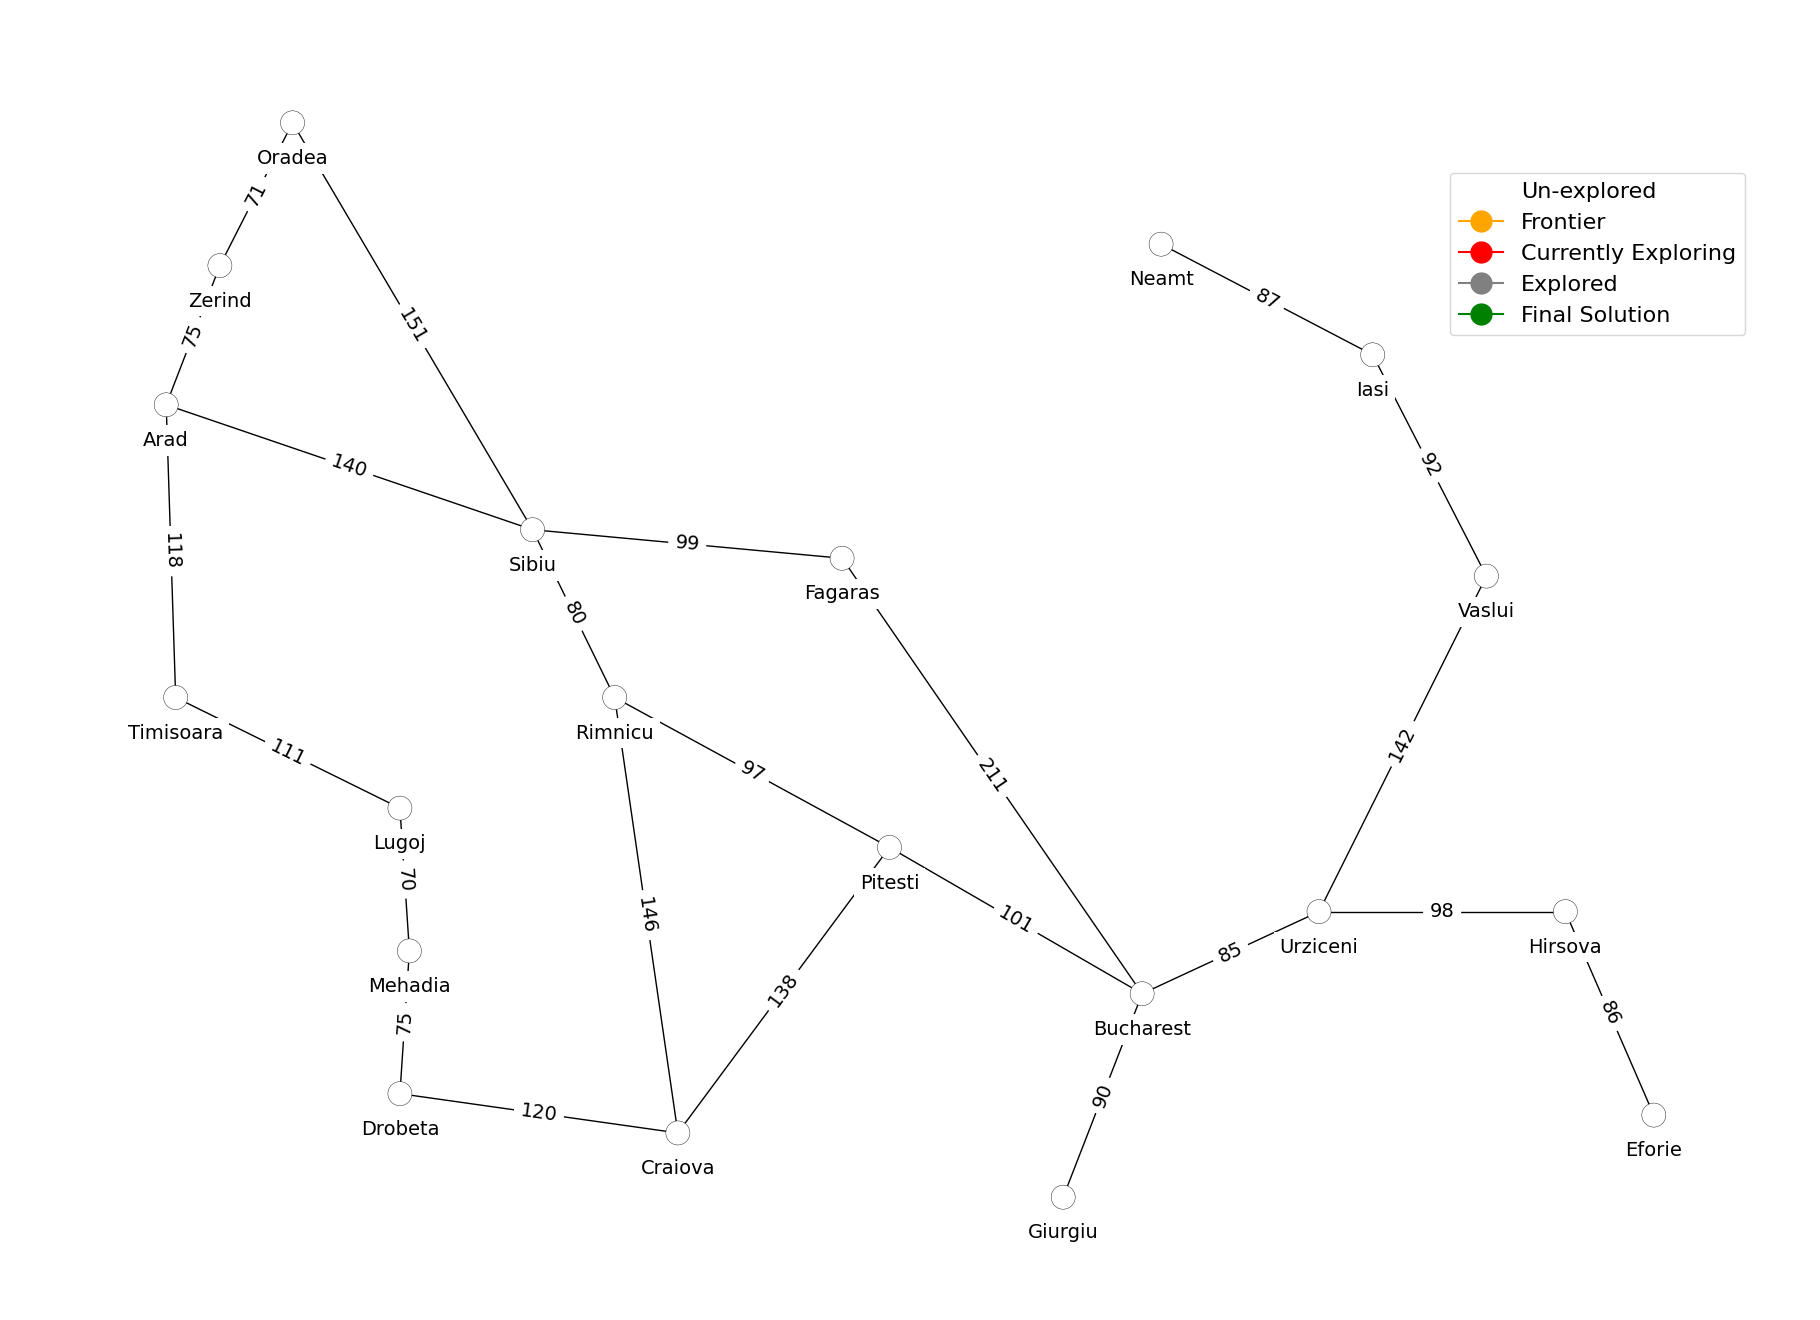

In [18]:
show_map(romania_graph_data)

Voila! You see, the romania map as shown in the Figure[3.2] in the book. Now, see how different searching algorithms perform with our problem statements.

We add the colors to the nodes to have a nice visualisation when displaying. So, these are the different colors we are using in these visuals:

* Un-explored nodes - white
* Frontier nodes - <font color='orange'>orange</font>
* Currently exploring nodes - <font color='red'>red</font>
* Already explored nodes - <font color='gray'>gray</font>
* Solution path (after the solution has been found) - <font color='green'>green</font>

In the initial state of our Romania route finding problem, we are located in `Arad`. Thus, `Arad` is the only node in our frontier while the other nodes remain un-explored. This could be visualised as follows:



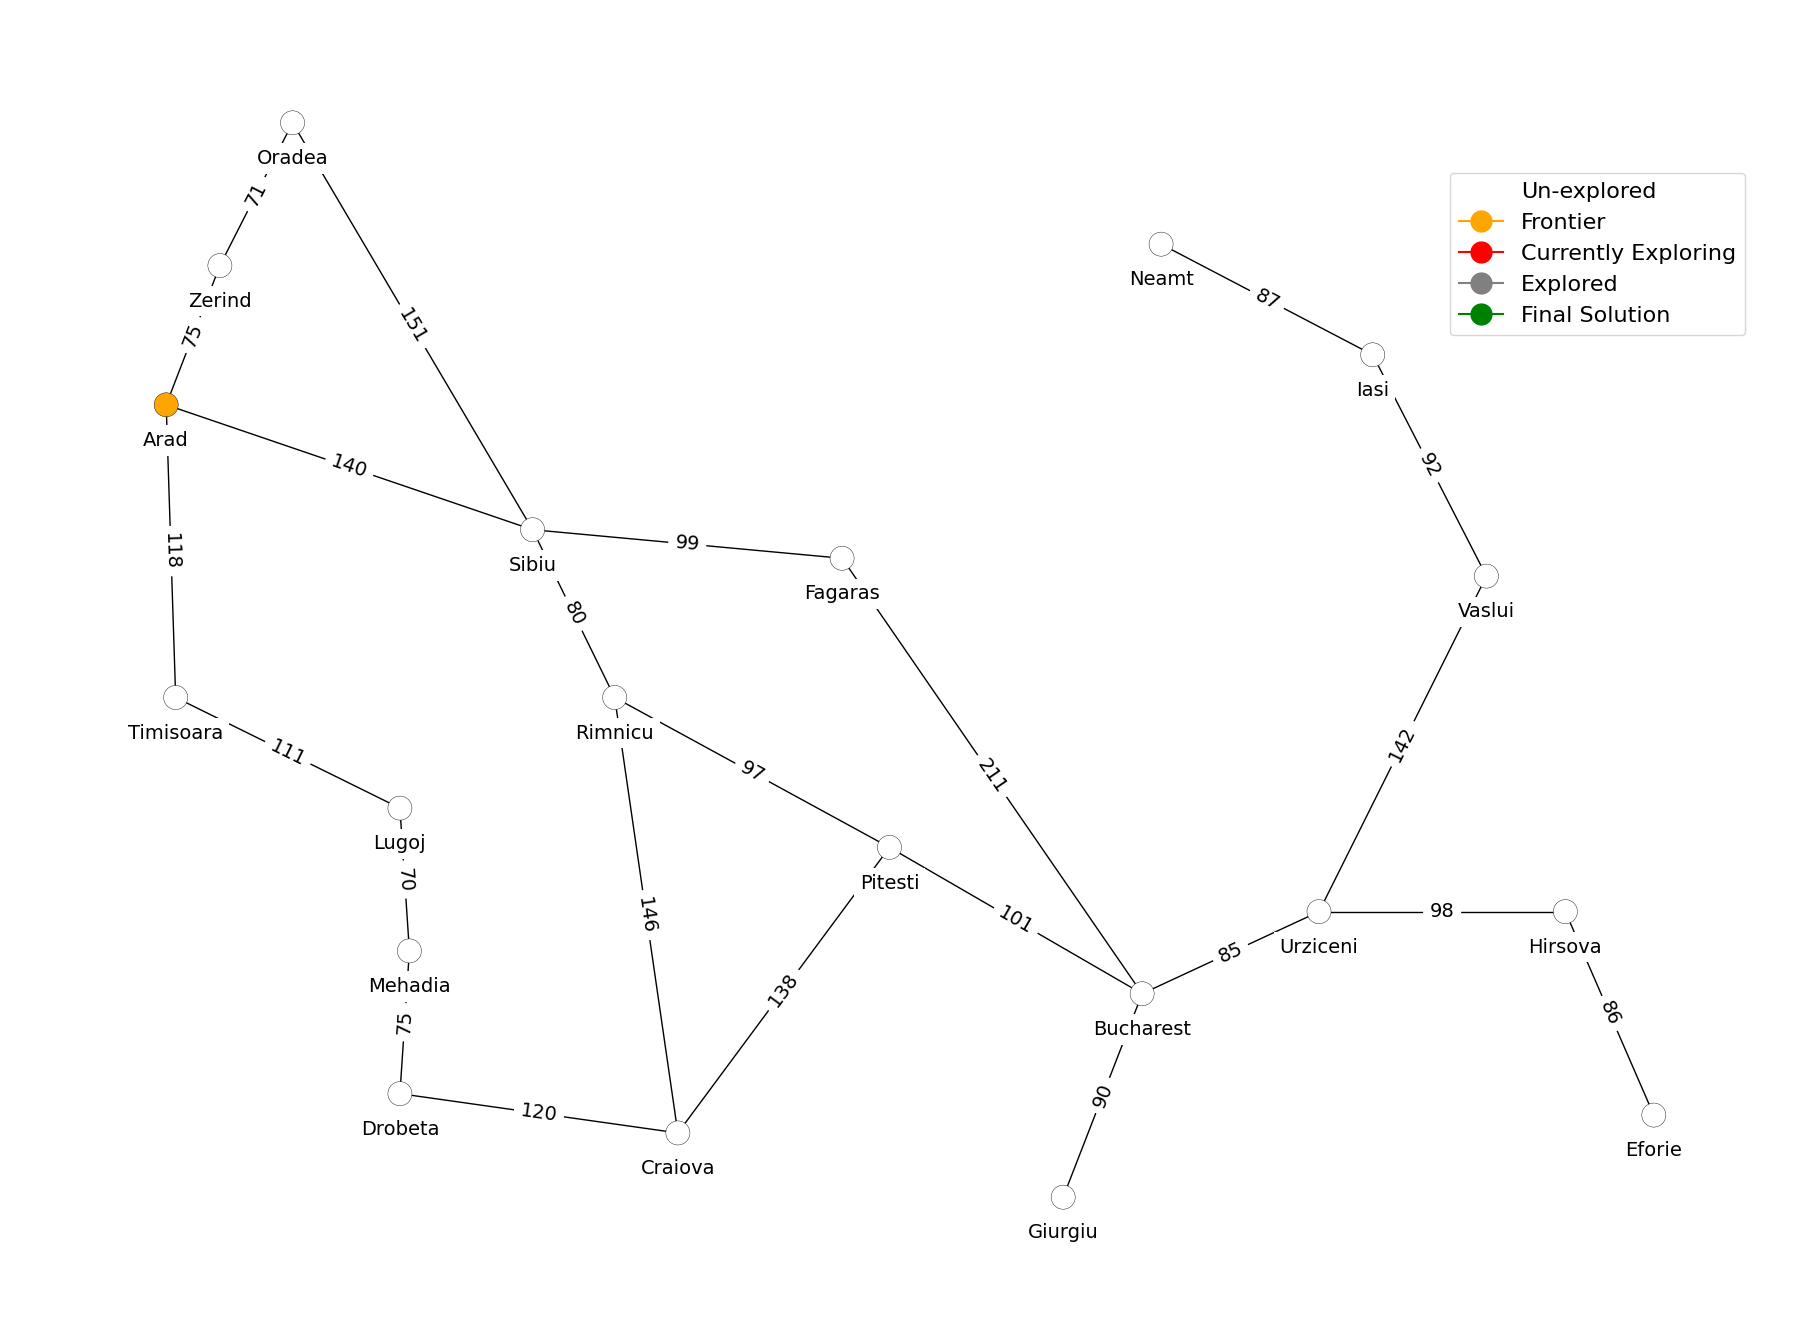

In [19]:
initial_node_colors = dict(node_colors)
initial_node_colors['Arad'] = 'orange'
show_map(romania_graph_data, node_colors=initial_node_colors)

For conciseness, class `GraphSearchRecorder` defines helper methods for recording and visualising which nodes and paths are being visited during the search:

In [20]:
psource(GraphSearchRecorder)

## ACTIVITY 1. BREADTH-FIRST TREE SEARCH

Now that we have understood the basics of defining a problem and visualising it, we can look at the different serach algorithms that we can use to solve the problems.
We have learned about several search strategy, such as breadth-first, depth-first, and best-first search strategies for trees and graphs. Recall that tree search methods don't remember which states have already been visited, whereas graph search algorithms take extra effort to detect that revisiting such a state is redundant.

In the following, we will implement some of them and visualise how they traverse the state space defining the problem to be solved.

We begin by considering tree search methods, in particular, the Breadth First Tree Search algorithm. Recall that this algorithm constructs a search tree starting at the initial state by exploring the search space level-by-level (where levels are distinguished by the number of actions that are applied to reach a state in the level from the initial state).

This algorith relies on a data structure, the **frontier**, that contains the states that have been reached but not yet explored. As the search progresses, a state is removed from the frontier, explored, and the successors in the next level that are reachable from the current state are added to the frontier for later processing. The search stops once a goal state has been reached.

The overall algorithm can be summarised as follows:

1. return if the initial state is a goal state
2. initialise the frontier with the initial state
3. Retrieve a node from the frontier.
4. Append each node that is reachable from the current node to the frontier, unless the node represents a goal state
5. If a goal node is encountered, return a solution
6. Repeat from 3. until the frontier is empty or a solution has been found

For example, starting the search in the initial state `Arad`, there are three locations that are reachable by using a single action: `Timisioara`, `Sibiu`, and `Zerind`. Hence, the algorithm would first visit Arad, then (in any order) these three states. Then, the states that are directly reachable form these three: `Oradea`, `Fagaras`, `Rimnicu`, `Lugoj`, and `Arad`. `Arad` is considered again, since the algorithm does not keep track of which states have already been visited. This process continues until the path to the goal is found: `Arad`, `Sibiu`, `Fagaras`, `Bucharest`.

To achieve a level-wise traversal of the search tree, the current state to be explored is retrieved from the start of the frontier, whereas the successors of the explored states are appended at the end of the frontier.

The code fragment below shows the overall outline of an implementation of the Breadth-First Tree Search Algorithm. This implementation contains some extra code that records the paths and nodes that are visited during the search. We will use the recorded information to visualise the search progress later.

However, in the code below, the data structure for the fontier are still missing.

## Choose a Data Structure

Your fist hands-on activity is to choose a suitable data structure for the frontier and complete the implementation below.
Consider the operations (removing from the front and adding to the end of the frontier) carried out by the algorithm.

Which data structure would efficiently support these operations?

Although the `list` data structure can do this in principle, it is not efficient. (Why?)
Consider alternative data structures that may be more efficient than lists:
* set <https://docs.python.org/3/tutorial/datastructures.html>
* dictionary <https://docs.python.org/3/tutorial/datastructures.html>
* queue <https://docs.python.org/3/library/queue.html>
* deque <https://docs.python.org/3/library/collections.html>
* heap (a.k.a. priority queue) <https://docs.python.org/3/library/heapq.html>
* a custom implementation of a linked-list

Which of them would be most efficient for managing the frontier? Why?

Once you have made your decision, complete the three missing fragments marked TODO in the code below.

In [24]:
def breadth_first_tree_search(problem):
    """Search through the successors of a problem to find a goal.
    Don't worry about repeated paths to a state.
    Record the events that are occurring during the search."""

    # we use the recorder object to record events during the search
    recorder = GraphSearchRecorder(problem)

    initial_node = Node(problem.initial)

    if problem.goal_test(initial_node.state):
        recorder.goal_found(initial_node)
        return (recorder, initial_node)

    # adding first node to the queue
    # TODO: initialise the frontier data structure
    #
    frontier = deque([initial_node])
    #
    recorder.added_to_frontier([initial_node])

    while frontier:

        #TODO: retrieve the next node from the frontier
        #
        node = frontier.popleft()
        #
        recorder.visited(node)

        # modify the color of explored nodes to gray
        # this is for visualisation only, since this algorithm
        # does not keep track of explored nodes
        recorder.explored(node)

        # add child nodes to the frontier (or return if a child is a goal)
        child_nodes = node.expand(problem)
        for child_node in child_nodes:
            if problem.goal_test(child_node.state):
                recorder.goal_found(child_node, record_path=True)
                return (recorder, child_node)
            #
            #TODO: insert child_node into the frontier
            #
            frontier.append(child_node)
            #
            recorder.added_to_frontier(child_node)

    # no solution found
    return (recorder, None)

Now, let's run the code and check if it works as expected. We print the paths and verify that

a) the algorithm considers the paths in the correct order, and

b) the correct path to the goal is found.

In [25]:
recorder, goal_node = breadth_first_tree_search(romania_problem)
recorder.print_visited_paths()

Explored path at iterations:
1: 
6: Zerind
10: Sibiu
16: Timisoara
20: Zerind-Arad
25: Zerind-Oradea
29: Sibiu-Arad
34: Sibiu-Fagaras
37: Sibiu-Fagaras-Bucharest


If your algorithm works correctly, you should see this output (paths of equal length may appear in different order without affecting correctness):
```
Explored path at iterations:
1:
6: Zerind
10: Sibiu
16: Timisoara
20: Zerind-Arad
25: Zerind-Oradea
29: Sibiu-Arad
34: Sibiu-Fagaras
37: Sibiu-Fagaras-Bucharest
```

Each line in this output corresponds to a sequence of actions that are explored by the algorithm. For example, the line tagged `6` corresponds to the action of moving from `Arad` to `Zerind` (since `Arad` is the initial state, which is not shown in the paths printed here). The path tagged `37` represents a path from `Arad` to `Bucharest` via  `Sibiu` and `Fagaras`. This is the correct solution that Breadth-First search computes. Hopefully, your implementation achieves the same. If not please debug it until it is correct.

We can also visualise the evolution of the search on the map:

In [26]:
recorder.visualise_search_progress(romania_graph_data)

interactive(children=(IntSlider(value=0, description='iteration', max=37), Output()), _dom_classes=('widget-in…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

You can use the slider to see how the search evolves, or press the `visualize` button to play an animation. By sliding the slider we can have a look at all the intermediate steps of a particular search algorithm. By pressing the button **Visualize**, you can see all the steps without interacting with the slider.

If you look closely at the nodes that are explored, do you notice anything unusual? Is the algorithm as efficient as it could be? How often do we examine `Arad`?

## ACTIVITY 2. BREADTH-FIRST GRAPH SEARCH

Clearly, tree search is not very efficient for our Romania graph, since there are multiple paths to the same cities, which cause quite a lot of redundant work. While this may be tolerable for a small graph such as the Romania map, for larger problems such redundant explorations can mean our algorithm may run for hours or days instead of seconds. We should adopt graph-search for this problem. Recall that the main difference between Tree Search and Graph Search is that the latter keep additional information so that it can detect if a state has already been visited. If that is the case, then no node will be added for that state to the frontier, which prevents the redundant work (at the expense of increasing the memory footprint of the algorithm.)

Let's modify the breadth-first tree search so that it can handle graph problems efficiently. Before adding a new node to the frontier, we must check that the corresponding state is not already included in the frontier and that it has not already been visited previously. We will need to keep a separate data structure, called `explored`, for the latter test.

What data structure shall we choose for `explored`? Consider that this data structure must provide efficient operations for adding an element and testing if an element is included.

Once you have chosen a suitable data structure, implement the Breadth-First Graph Search algorithm, and check that it works correctly.

In [33]:
def breadth_first_graph_search(problem):
    """Search through the successors of a problem to find a goal.
    Detect repeated paths to a state.
    Record the events that are occurring during the search."""

    # we use the recorder object to record events during the search
    recorder = GraphSearchRecorder(problem)

    initial_node = Node(problem.initial)

    if problem.goal_test(initial_node.state):
        recorder.goal_found(initial_node)
        return (recorder, initial_node)

    # adding first node to the queue
    # TODO: initialize the frontier data structure
    #
    frontier = deque([initial_node])
    #
    recorder.added_to_frontier(initial_node)

    # TODO: initialize explored
    explored = set()
    #

    while frontier:

        #TODO: retrieve the next node from the frontier
        #
        node = frontier.popleft()
        explored.add(node)
        #
        recorder.visited(node)

        # modify the color of explored nodes to gray
        # this is for visualisation only, since this algorithm
        # does not keep track of explored nodes
        recorder.explored(node)

        # add child nodes to the frontier (or return if a child is a goal)
        child_nodes = node.expand(problem)
        for child_node in child_nodes:

            if problem.goal_test(child_node.state):
                recorder.goal_found(child_node, record_path=True)
                return (recorder, child_node)
            elif child_node not in explored and child_node not in frontier:
              frontier.append(child_node)
              #
              recorder.added_to_frontier(child_node)


    # no solution found
    return (recorder, None)


In [34]:
recorder, goal_node = breadth_first_graph_search(romania_problem)
recorder.print_visited_paths()

Explored path at iterations:
1: 
6: Zerind
9: Sibiu
13: Timisoara
16: Zerind-Oradea
18: Sibiu-Fagaras
20: Sibiu-Fagaras-Bucharest


If your algorihtm works correclty, you should see the following output (paths of equal length may appear in different order without affecting correctness):
```
Explored path at iterations:
1:
6: Zerind
9: Sibiu
13: Timisoara
16: Zerind-Oradea
18: Sibiu-Fagaras
20: Sibiu-Fagaras-Bucharest
```
As you can see, the algorithm does less work than the tree search variant, and there are no redundant paths.


In [36]:
recorder.visualise_search_progress(romania_graph_data)

interactive(children=(IntSlider(value=0, description='iteration', max=20), Output()), _dom_classes=('widget-in…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## ACTIVITY 3. BEST FIRST SEARCH

Breadth-First search can be useful if we are seeking the solution with smallest number of actions. However, for many scenarios, we are looking to find a solution that minimises some other metric, such as costs. In the Romania map example, we are seeking to find the shortest path (that minimises the total distance travelled) from `Arad` to `Bucharest`. To achieve this, we must take into consideration the costs associated with each edge in the graph.

Best-First search is an algorithm that can find solutions that minimise costs. Conceptually, it is similar to Breadth-First Search, but differs in three crucial aspects:
1) The order in which the nodes are retrieved from the frontier is determined by the cost associated with a node, not the number of actions/level in the tree.
2) The costs associated with nodes in the frontier may need to be revised, since a node may be superseded by a subsequent node that ends in the same state yet has lower associated costs.
3) The "shortcut" that we can stop searching once a goal node is encountered during expansion of a node is no longer valid. We must search until a goal node has become the current visited node, that is, until a goal node has been **retrieved** from the frontier.

In the following, you will implement a version of Best-First Graph Search.

First, we discuss what data structure is best suited for managing the frontier. Best-First Search requires to retrieve the element with lowest cost from the frontier, and insert new nodes at a position determined by their costs in the frontier, and replace entries that are superseded by other nodes. Among the candidate data structures that were considered when implementing the Breadth-First Search algorithm, the Priority Queue structure mostly satisfies these requirements. We can use the implementation provided in file `utils.py`.

You can implement the Best-First Search algorithm:

In [46]:
def best_first_graph_search(problem):
    """Search through the successors of a problem to find a goal.
    Consider the cost of actions.
    Detect repeated paths to a state.
    Record the events that are occurring during the search."""

    # we use the recorder object to record events during the search
    recorder = GraphSearchRecorder(problem)

    initial_node = Node(problem.initial)
    frontier = PriorityQueue('min', lambda n: n.path_cost)
    frontier.append(initial_node)
    recorder.added_to_frontier(initial_node)

    explored = set()

    while frontier:

        node = frontier.pop()
        recorder.visited(node)

        if problem.goal_test(node.state):
                recorder.goal_found(node)
                return (recorder, node)
        explored.add(node)
        recorder.explored(node)

        child_nodes = node.expand(problem)
        for child_node in child_nodes:
            if child_node in explored:
              continue
            if(child_node not in frontier):
              frontier.append(child_node)
              recorder.added_to_frontier(child_node)
            else:
              incumbent_cost = frontier[child_node]
              print(incumbent_cost)
              if child_node.path_cost < incumbent_cost:
                  del frontier[child_node]
                  frontier.append(child_node)


    # no solution found
    return (recorder, None)

In [48]:
recorder, goal_node = best_first_graph_search(romania_problem)
recorder.print_visited_paths()
print(f"The cost of the solution path is {goal_node.path_cost}.")

146
450
366
374
Explored path at iterations:
1: 
6: Zerind
9: Timisoara
12: Sibiu
16: Zerind-Oradea
18: Sibiu-Rimnicu
22: Timisoara-Lugoj
25: Sibiu-Fagaras
28: Timisoara-Lugoj-Mehadia
31: Sibiu-Rimnicu-Pitesti
33: Sibiu-Rimnicu-Craiova
35: Timisoara-Lugoj-Mehadia-Drobeta
37: Sibiu-Rimnicu-Pitesti-Bucharest
The cost of the solution path is 418.


## ACTIVITY 4. DEPTH-FIRST TREE SEARCH
Now let's discuss another searching algorithm, Depth-First Tree Search. This algorithm explores the tree such that the current path is recursively before the alternative actions are being considered. This leads to a traversal that descends into deep paths in the tree before it looks at alternative paths.

The implementation for Depth-First Search is almost identical to that of BFS, except for the data structure used for the frontier. To achieve depth-first search, we must retrieve the current node from the end of the frontier, and also append new nodes to the end of the frontier. This will result in the nodes that are added last being the first to be explored.

If we were to implement this Depth-First algorithm for the Romania route finding problem, unfortunately, we would face the problem that the algorihtm would not terminate. This is because we can go from `Arad` to `Zerind` to `Arad` to `Zerind` ... forever without finding a goal node.

Hence, we will implement a variant of the search that stops extending the current path after a pre-set threshold on the number of actions in each path has been exceeded. This will avoid the infinite back-and-forth game and eventually explore other parts of the state space that may contain a goal state.

Implement a variant of Depth-First Search that stops expanding a path once the number of actions on that path are at or above the given limit. Moreover, return 'cutoff' if no solution is found but some paths in the search tree were cut due to exceeding the depth limit. We can use this information to see if it makes sense to re-try the search with an increased depth limit.


In [49]:
def depth_limited_tree_search(problem, limit=None):
    """Perform depth first search of the graph associated with problem.
    If limit >= 0, that is the maximum depth of the search."""

    # we use the recorder object to record events during the search
    recorder = GraphSearchRecorder(problem)

    initial_node = Node(problem.initial)
    frontier = [initial_node]
    recorder.added_to_frontier(initial_node)

    cutoff_occurred = False
    while frontier:

        node = frontier.pop()
        recorder.visited(node)

        if problem.goal_test(node.state):
            recorder.goal_found(node)
            return (recorder, node)

        # just for visualisation
        recorder.explored(node)

        if limit is not None and len(node.solution()) >= limit:
            cutoff_occurred = True
        else:
            child_nodes = node.expand(problem)
            for child_node in child_nodes:
                if child_node not in frontier:
                    frontier.append(child_node)
                    recorder.added_to_frontier(child_node)

    # no solution found
    return (recorder, 'cutoff' if cutoff_occurred else None)


Try running the algorithm with a depth limit of 2. What is the result?

In [50]:
recorder, goal_node = depth_limited_tree_search(romania_problem, limit=2)
recorder.print_visited_paths()
if goal_node is None:
    print("No solution.")
elif goal_node == 'cutoff':
    print("No solution found. The depth limit may be too low.")


Explored path at iterations:
1: 
6: Timisoara
10: Timisoara-Lugoj
12: Timisoara-Arad
14: Sibiu
20: Sibiu-Rimnicu
22: Sibiu-Oradea
24: Sibiu-Fagaras
26: Sibiu-Arad
28: Zerind
32: Zerind-Oradea
34: Zerind-Arad
No solution found. The depth limit may be too low.


Now, run the algorithm with depth limit set to 3.

In [51]:
recorder, goal_node = depth_limited_tree_search(romania_problem, limit=3)
recorder.print_visited_paths()
if goal_node is None:
    print("No solution.")
elif goal_node == 'cutoff':
    print("No solution found. The depth limit may be too low.")

Explored path at iterations:
1: 
6: Timisoara
10: Timisoara-Lugoj
14: Timisoara-Lugoj-Mehadia
16: Timisoara-Lugoj-Timisoara
18: Timisoara-Arad
21: Timisoara-Arad-Timisoara
23: Sibiu
29: Sibiu-Rimnicu
34: Sibiu-Rimnicu-Pitesti
36: Sibiu-Rimnicu-Craiova
38: Sibiu-Rimnicu-Sibiu
40: Sibiu-Oradea
43: Sibiu-Oradea-Sibiu
45: Sibiu-Fagaras
49: Sibiu-Fagaras-Bucharest


We have found a solution!

We can automate this process and invoke `dept_limited_tree_search` with limit set to 0,1,2,3,... until a solution is found or no cut-off occurs.

Implement a function `iterative_deepening_dept_first_search` that invokes the depth limited search with increasing limit until a solution is found (or a given maximal depth is reached). For purposes of this activity you can set the maximum depth to 15.

In [53]:
def iterative_deepening_dept_first_search(problem, max_depth=15):

    for limit in range(max_depth):
        print(f"\nlimit={limit}:")
        recorder, goal_node = depth_limited_tree_search(romania_problem, limit=limit)
        recorder.print_visited_paths()
        if goal_node is None or goal_node != 'cutoff':
            return (recorder, goal_node)
    return (recorder, None)

In [54]:
recorder, goal_node = iterative_deepening_dept_first_search(romania_problem)


limit=0:
Explored path at iterations:
1: 

limit=1:
Explored path at iterations:
1: 
6: Timisoara
8: Sibiu
10: Zerind

limit=2:
Explored path at iterations:
1: 
6: Timisoara
10: Timisoara-Lugoj
12: Timisoara-Arad
14: Sibiu
20: Sibiu-Rimnicu
22: Sibiu-Oradea
24: Sibiu-Fagaras
26: Sibiu-Arad
28: Zerind
32: Zerind-Oradea
34: Zerind-Arad

limit=3:
Explored path at iterations:
1: 
6: Timisoara
10: Timisoara-Lugoj
14: Timisoara-Lugoj-Mehadia
16: Timisoara-Lugoj-Timisoara
18: Timisoara-Arad
21: Timisoara-Arad-Timisoara
23: Sibiu
29: Sibiu-Rimnicu
34: Sibiu-Rimnicu-Pitesti
36: Sibiu-Rimnicu-Craiova
38: Sibiu-Rimnicu-Sibiu
40: Sibiu-Oradea
43: Sibiu-Oradea-Sibiu
45: Sibiu-Fagaras
49: Sibiu-Fagaras-Bucharest


We can observe that there are multiple invocations of depth-limited search. Each starts at the initial state (the empty path) and explores paths up to a given depth limit. We can also observe that the same states are explored multiple times. Obviously, the nodes near the root of the tree are traversed for almost every limit value. Moreover, the same states are visited multiple times even within a single depth-limited search. For example, `Timisoara` is visited three times in the last search. While this may seem inefficient, this approach has a significant advantage that the frontier remains small throughout the search. Its size is proportional to the search depth, which can be a big advantage if other algorithms, such as Best-First Search, run out of memory while keeping the frontier and explored set. The idea of iteratively increasing the depth limit can of course be combined with graph search ideas to limit the amount of redundant work that is performed in each iteration. There are also variants of this that work with cost thresholds rather than depth limits, for example RBFS (see the textbook if you are interested).

## TASK 5: SAVE YOUR WORK

Please remember to save your work. You will need some of it in the Week 3 Practical.

Next week, we will build on these algorithms and examine heuristic search methods that search even more efficiently by exploiting additional information about the problem that is being solved.

This concludes the notebook.
Hope you learned something new!